In [1]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.edgecolor"] = "none"

import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
mplhep.style.use(["CMS", "firamath"])

In [2]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [23]:
genvpt_axis = hist.axis.Regular(
    40, 0, 1500, name="vpt", label=r"Gen V p$_T$ [GeV]"
)
vpt_axis = hist.axis.Regular(
    40, 0, 1500, name="vpt", label=r"LHE V p$_T$ [GeV]"
)
lpt_axis = hist.axis.Regular(
    40, 0, 800, name="leppt", label=r"Reco Lepton p$_T$ [GeV]"
)
jpt_axis = hist.axis.Regular(
    40, 0, 1000, name="jetpt", label=r"Reco Jet p$_T$ [GeV]"
)
ht_axis = hist.axis.Regular(
    40, 0, 3000, name="ht", label=r"LHE HT [GeV]"
)
type_axis = hist.axis.StrCategory([], name="ctype", growth=True)
sample_axis = hist.axis.StrCategory([], name="scat", growth=True)

h_vpt = hist.Hist(vpt_axis, sample_axis)
h_vpt_noweight = hist.Hist(vpt_axis, sample_axis)
h_vpt_nocorr = hist.Hist(vpt_axis, sample_axis)
h_vpt_oldcorr = hist.Hist(vpt_axis, sample_axis)
h_vpt_noewkcorr = hist.Hist(vpt_axis, sample_axis)

h_genvpt = hist.Hist(genvpt_axis, sample_axis)
h_genvpt_nocorr = hist.Hist(genvpt_axis, sample_axis)
h_genvpt_oldcorr = hist.Hist(genvpt_axis, sample_axis)
h_genvpt_noewkcorr = hist.Hist(genvpt_axis, sample_axis)

h_ht = hist.Hist(ht_axis, sample_axis)
h_ht_ind = hist.Hist(ht_axis, sample_axis)

h_corr = hist.Hist(genvpt_axis, sample_axis, type_axis)


h_lpt = hist.Hist(lpt_axis, sample_axis)
h_lpt_oldcorr = hist.Hist(lpt_axis, sample_axis)

h_jpt = hist.Hist(jpt_axis, sample_axis)


odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan15_vjets_lepsel_vpt_2018/"
ch = "mu"
year = "2018"
samples_dict = {
    "WJetsNLO": [
        #"WJetsToLNu_0J",
        "WJetsToLNu_1J",
        "WJetsToLNu_2J",
    ],
    "WJetsLO-HT": [
        "WJetsToLNu_TuneCP5_13TeV-madgraphMLM",
        #"WJetsToLNu_HT-70To100",
        "WJetsToLNu_HT-100To200",
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
}
extra_dict = {
    "DYJetsLO-HT": [
        "DYJetsToLL_M-10to50",
        "DYJetsToLL_M-50",
        #"DYJetsToLL_M-50_HT-70to100",
        "DYJetsToLL_M-50_HT-100to200",
        "DYJetsToLL_M-50_HT-200to400",
        "DYJetsToLL_M-50_HT-400to600",
        "DYJetsToLL_M-50_HT-600to800",
        "DYJetsToLL_M-50_HT-800to1200",
        "DYJetsToLL_M-50_HT-1200to2500",
        "DYJetsToLL_M-50_HT-2500toInf",
    ],
    "DYJetsNLO": [
        "DYJetsToLL_LHEFilterPtZ-0To50",
        "DYJetsToLL_LHEFilterPtZ-50To100",
        "DYJetsToLL_LHEFilterPtZ-100To250",
        "DYJetsToLL_LHEFilterPtZ-250To400",
        "DYJetsToLL_LHEFilterPtZ-400To650",
        "DYJetsToLL_LHEFilterPtZ-650ToInf",
    ],
}

weight_wjets = {
    "WJetsToLNu_1J": 1,
    "WJetsToLNu_2J": 1,
    "WJetsToLNu_TuneCP5_13TeV-madgraphMLM": 1,
    "WJetsToLNu_HT-70To100": 1.21,
    "WJetsToLNu_HT-100To200": 0.993,
    "WJetsToLNu_HT-200To400": 1.002,
    "WJetsToLNu_HT-400To600": 1.009,
    "WJetsToLNu_HT-600To800": 1.120,
    "WJetsToLNu_HT-800To1200": 1.202,
    "WJetsToLNu_HT-1200To2500": 1.332,
    "WJetsToLNu_HT-2500ToInf": 4.2,
}

for key,samples in samples_dict.items():
    outdir = odir
        
    for sample in samples:
        if "WJetsToLNu_HT-" in sample:
            outdir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_vjets_lepsel_vpt_2018"

        parquet_files = glob.glob(f"{outdir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{outdir}/{sample}/outfiles/*.pkl")
        print(sample)

        columns = [
            "gen_V_pt",
            "LHE_HT", 
            "LHE_Vpt", 
            f"weight_{ch}",
            "ewk_corr", 
            "oldqcd_corr", 
            "qcd_corr", 
            "lep_pt",
            "fj_pt",
        ]
        data = pd.read_parquet(parquet_files, columns=columns)

        luminosity = 59781.96

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"]

        if sample=="WJetsToLNu_TuneCP5_13TeV-madgraphMLM" or sample=="DYJetsToLL_M-50":
            selection = (data["LHE_HT"] > 0)
            data = data[selection]
            event_weight = event_weight[selection]

        if len(data) <= 0: continue
        leppt = data["lep_pt"].values
        h_lpt.fill(leppt, key, weight=event_weight)

        jpt = data["fj_pt"].values
        h_jpt.fill(jpt, key, weight=event_weight)

        hpt = data["LHE_Vpt"].values
        h_vpt.fill(hpt, key, weight=event_weight)
        h_vpt_noweight.fill(hpt, key)

        genvpt = data["gen_V_pt"].values
        h_genvpt.fill(genvpt, key, weight=event_weight)

        if "NLO" in sample:
            h_vpt_nocorr.fill(hpt, key, weight=event_weight)
            h_genvpt_nocorr.fill(genvpt, key, weight=event_weight)

            h_corr.fill(genvpt, key, "vhbb", weight=event_weight*data["qcd_corr"].values)
            h_corr.fill(genvpt, key, "boostedhbb", weight=event_weight*data["oldqcd_corr"].values)

            h_lpt_oldcorr.fill(leppt, key, weight=event_weight)
        else:
            qcd_corr = data["qcd_corr"].values
            inv_qcd_corr = np.nan_to_num(1/data["qcd_corr"])
            w = event_weight*inv_qcd_corr
            h_vpt_nocorr.fill(hpt, key, weight=w)
            h_genvpt_nocorr.fill(genvpt, key, weight=w)

            w = event_weight*inv_qcd_corr*data["oldqcd_corr"].values
            h_vpt_oldcorr.fill(hpt, key, weight=w)
            h_genvpt_oldcorr.fill(genvpt, key, weight=w)
            h_lpt_oldcorr.fill(leppt, key, weight=w)

            h_corr.fill(genvpt, key, "vhbb", weight=event_weight*inv_qcd_corr*data["qcd_corr"].values)
            h_corr.fill(genvpt, key, "boostedhbb", weight=event_weight*inv_qcd_corr*data["oldqcd_corr"].values)

        inv_ewk_corr = np.nan_to_num(1/data["ewk_corr"].values)
        w = event_weight*inv_ewk_corr*inv_qcd_corr*data["oldqcd_corr"].values
        h_vpt_noewkcorr.fill(hpt, key, weight=w)
        h_genvpt_noewkcorr.fill(genvpt, key, weight=w)
        
        ht = data["LHE_HT"].values
        h_ht.fill(ht, key, weight=event_weight)
        h_ht_ind.fill(ht, sample, weight=event_weight*weight_wjets[sample])

WJetsToLNu_1J
WJetsToLNu_2J
WJetsToLNu_TuneCP5_13TeV-madgraphMLM
WJetsToLNu_HT-100To200
WJetsToLNu_HT-200To400
WJetsToLNu_HT-400To600
WJetsToLNu_HT-600To800
WJetsToLNu_HT-800To1200
WJetsToLNu_HT-1200To2500
WJetsToLNu_HT-2500ToInf


Correction

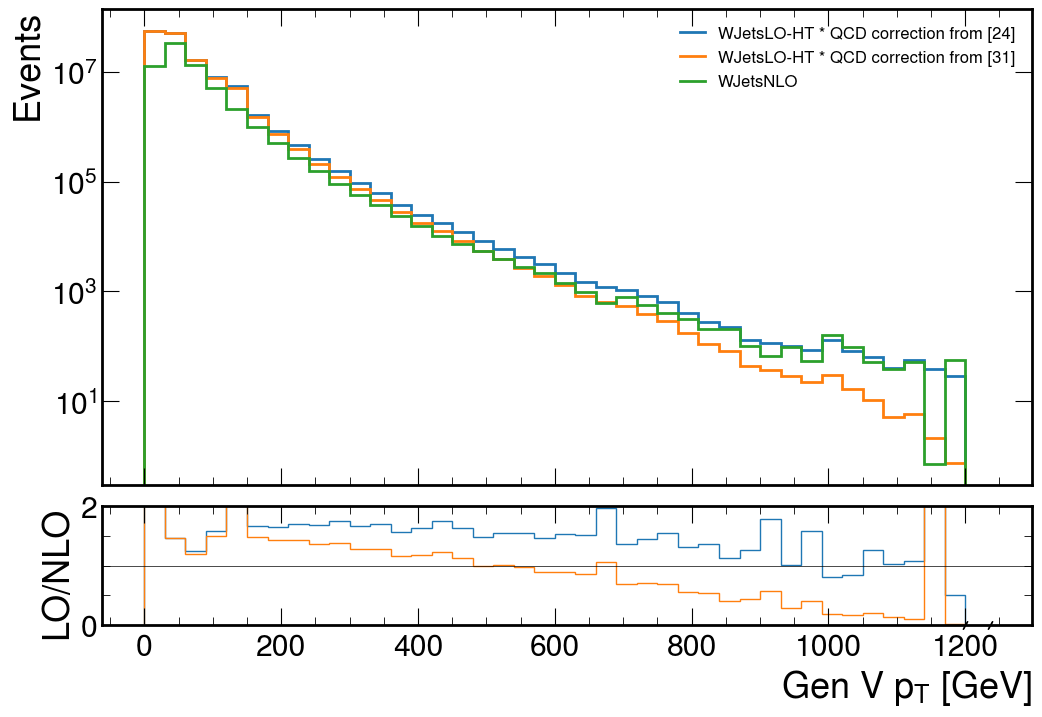

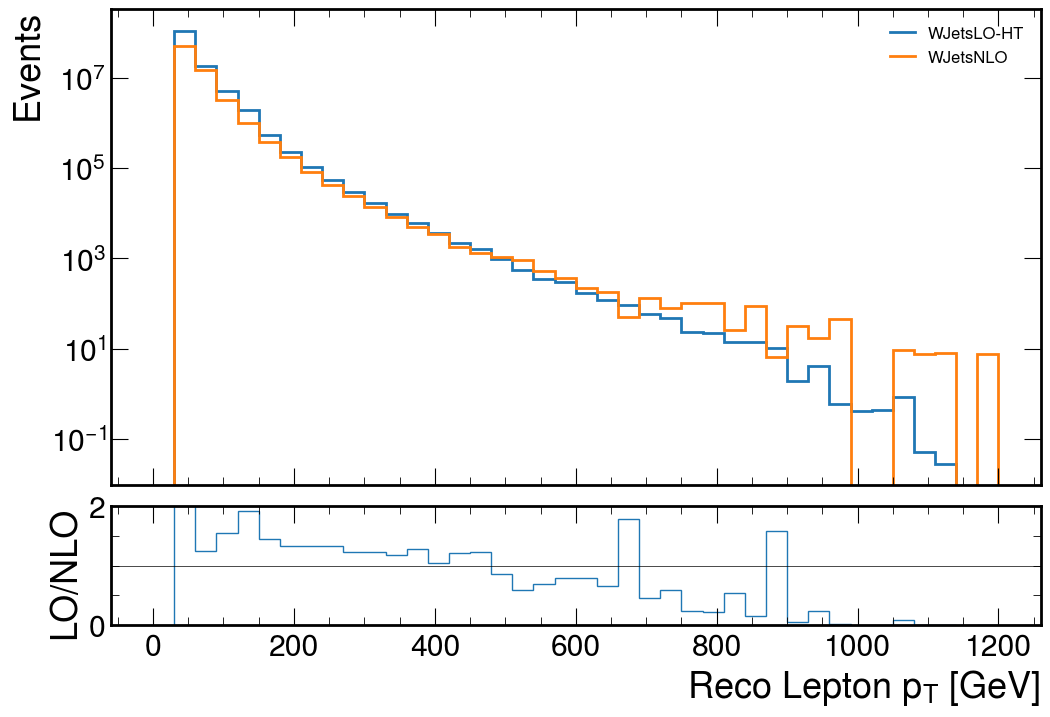

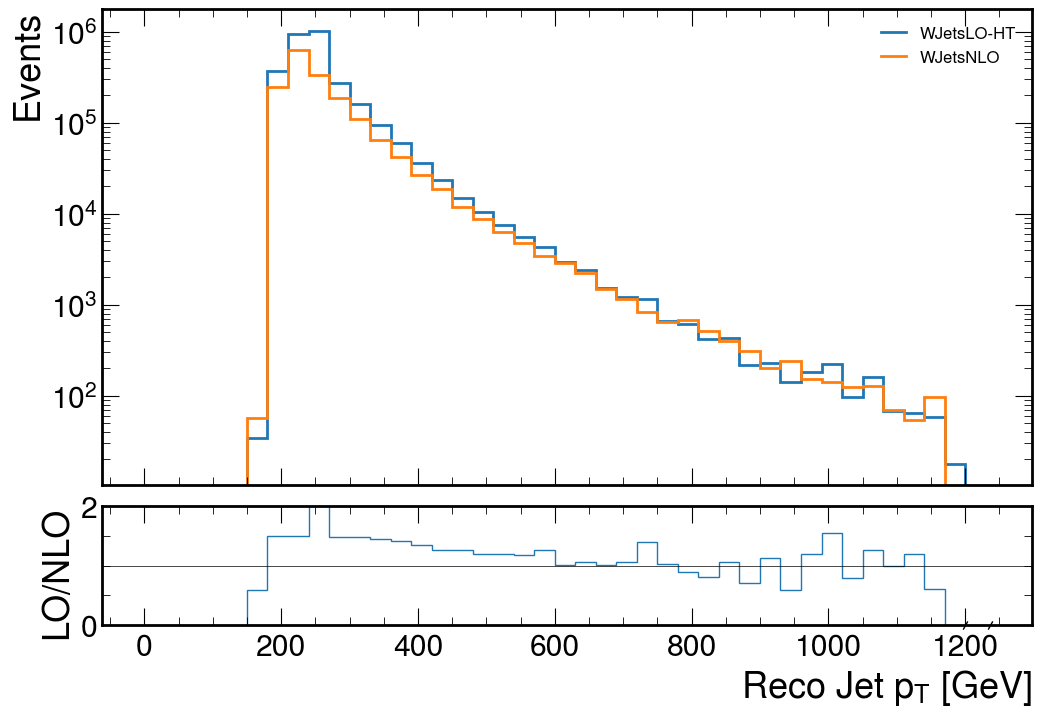

In [22]:
refs = {
    "boostedhbb": "[24]",
    "vhbb": "[31]",
}
fig, (ax, rax) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07}, sharex=True)
legend_elements = []
for key in ["WJetsLO-HT"]:
    for corr in ["boostedhbb", "vhbb"]:
        h = h_corr[{"scat": key, "ctype": corr}]
        mplhep.histplot(h, lw=2, flow="none", label=f"{key} * QCD correction from {refs[corr]}", ax=ax)
h = h_corr[{"scat": "WJetsNLO", "ctype": "boostedhbb"}]
mplhep.histplot(h, lw=2, flow="none", label=f"WJetsNLO", ax=ax)
for corr in ["boostedhbb", "vhbb"]:
    ratio = h_corr[{"scat": "WJetsLO-HT", "ctype": corr}] / h_corr[{"scat": "WJetsNLO", "ctype": corr}]
    mplhep.histplot(ratio, ax=rax)
ax.set_xlabel("")
ax.set_ylabel("Events")
ax.legend(fontsize=12)
ax.set_yscale("log")
rax.set_ylabel("LO/NLO")
rax.set_ylim(0, 2)
rax.axhline(y = 1, color = 'k', linestyle = '-', linewidth=0.5) 
fig.savefig("genvpt_lepsel_wjets_v23.png")

fig, (ax, rax) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07}, sharex=True)
legend_elements = []
for key in ["WJetsLO-HT","WJetsNLO"]:
    # h = h_lpt_oldcorr[{"scat": key}]
    h = h_lpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key, ax=ax)
ratio = h_lpt[{"scat": "WJetsLO-HT"}] / h_lpt[{"scat": "WJetsNLO"}]
mplhep.histplot(ratio, ax=rax)
ax.legend(fontsize=12)
ax.set_xlabel("")
ax.set_ylabel("Events")
rax.set_ylabel("LO/NLO")
ax.set_yscale("log")
rax.set_ylim(0, 2)
rax.axhline(y = 1, color = 'k', linestyle = '-', linewidth=0.5) 
fig.savefig("recoleppt_lepsel_wjets_v23.png")

fig, (ax, rax) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07}, sharex=True)
legend_elements = []
for key in ["WJetsLO-HT","WJetsNLO"]:
    h = h_jpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key, ax=ax)
ratio = h_jpt[{"scat": "WJetsLO-HT"}] / h_jpt[{"scat": "WJetsNLO"}]
mplhep.histplot(ratio, ax=rax)
ax.legend(fontsize=12)
ax.set_xlabel("")
ax.set_ylabel("Events")
rax.set_ylabel("LO/NLO")
ax.set_yscale("log")
rax.set_ylim(0, 2)
rax.axhline(y = 1, color = 'k', linestyle = '-', linewidth=0.5) 
fig.savefig("recojpt_lepsel_wjets_v23.png")



V pt

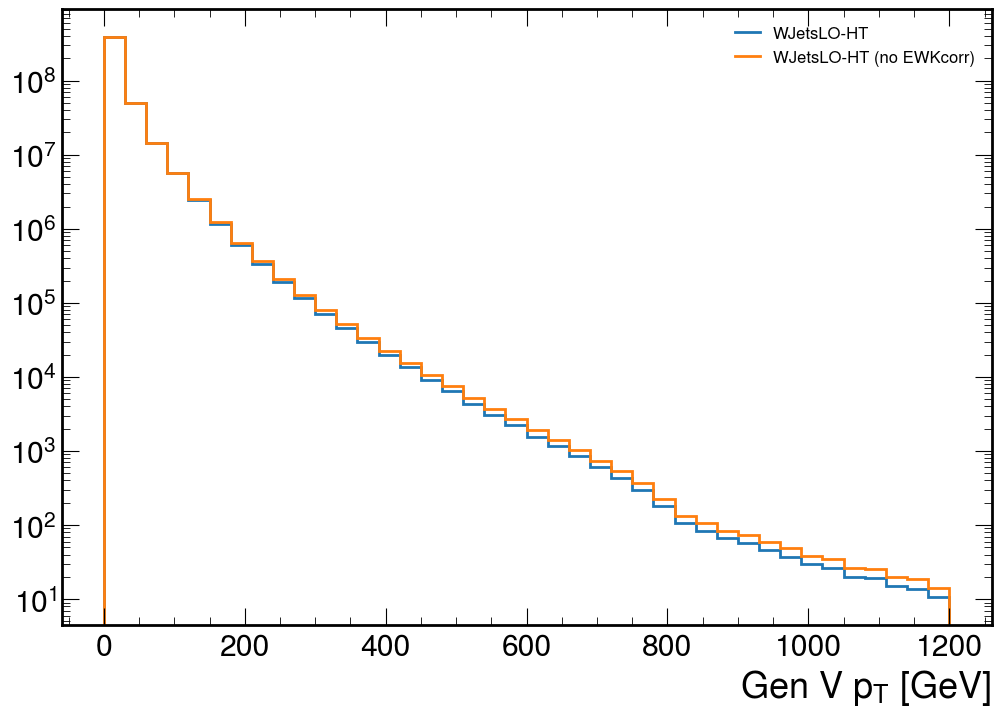

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
#for key in ["WJetsNLO", "WJetsLO-HT"]:
#    h = h_genvpt[{"scat": key}]
#    mplhep.histplot(h, lw=2, flow="none", label=key)
mplhep.histplot(h_genvpt_oldcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT")
mplhep.histplot(h_genvpt_noewkcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (no EWKcorr)")
#mplhep.histplot(h_genvpt_noewkcorr[{"scat": "WJetsNLO"}], lw=2, flow="none", label="WJetsNLO (no EWKcorr)")
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("genvpt_lepsel_wjets_ewk.png")


Lepton pT

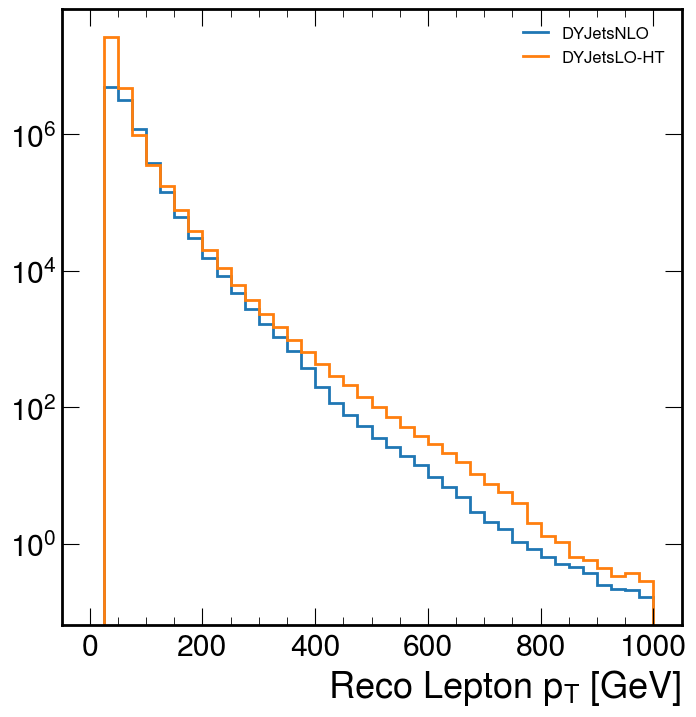

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_lpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")


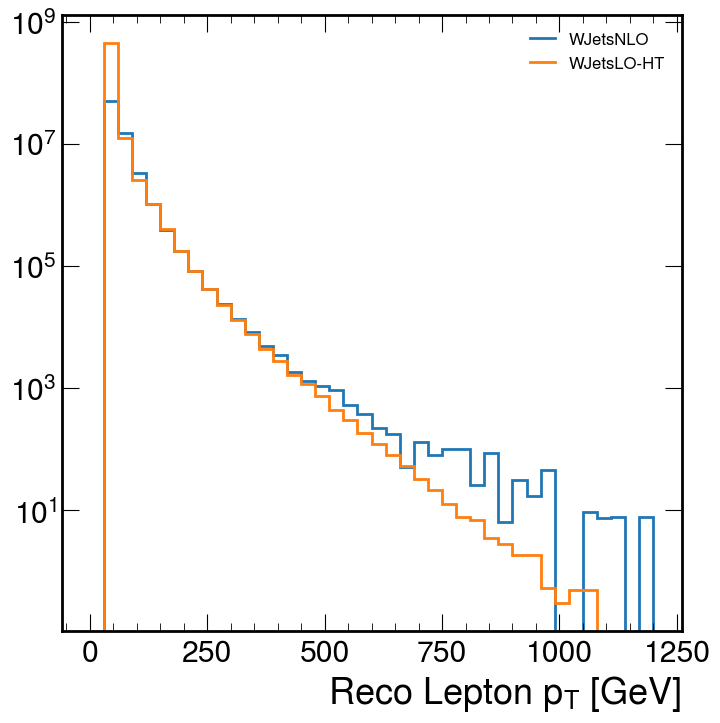

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_lpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
ax.legend(fontsize=12)
ax.set_yscale("log")

V pt

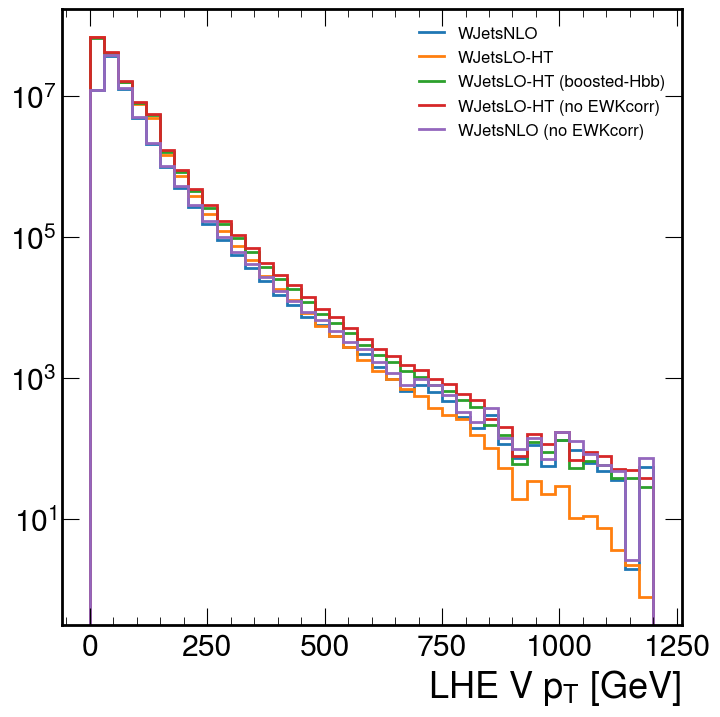

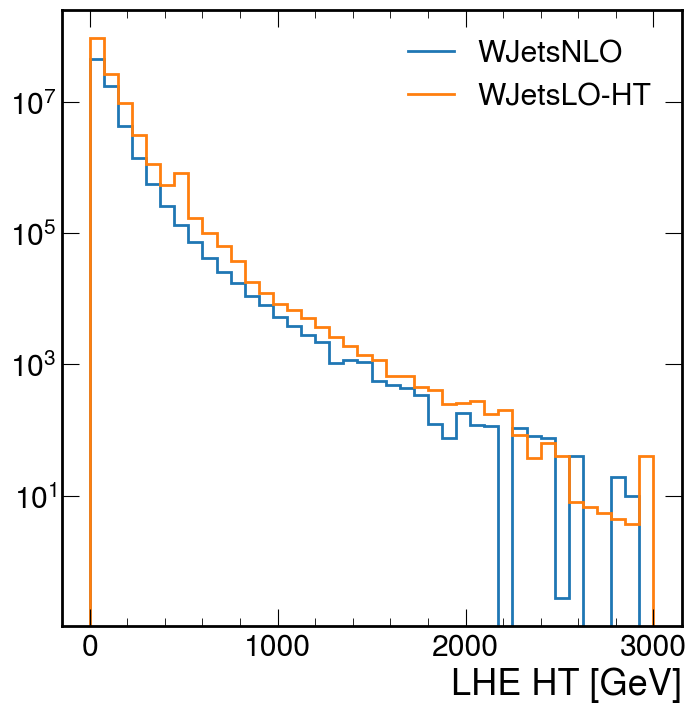

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
mplhep.histplot(h_vpt_oldcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (boosted-Hbb)")
mplhep.histplot(h_vpt_noewkcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (no EWKcorr)")
mplhep.histplot(h_vpt_noewkcorr[{"scat": "WJetsNLO"}], lw=2, flow="none", label="WJetsNLO (no EWKcorr)")
ax.legend(fontsize=12)
ax.set_yscale("log")

fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_ht[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        flow="none",
        label=key,
    )
ax.legend()
ax.set_yscale("log")


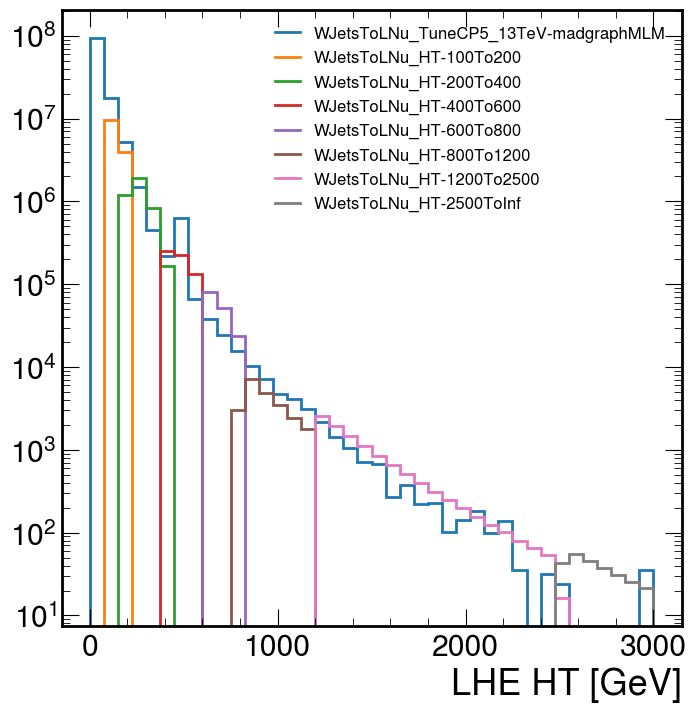

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in samples_dict["WJetsLO-HT"]:
    #if key == "WJetsToLNu_TuneCP5_13TeV-madgraphMLM": continue
    h = h_ht_ind[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        #density=True,
        flow="none",
        label=key,
    )
ax.legend(fontsize=12)
ax.set_yscale("log")

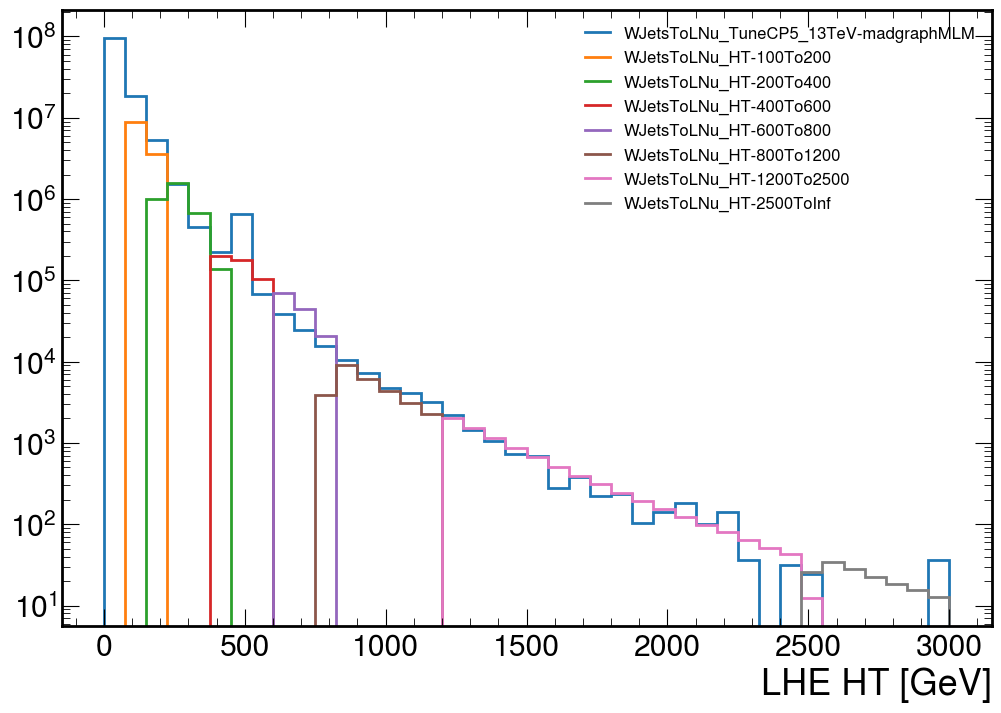

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
for key in samples_dict["WJetsLO-HT"]:
    # if key == "WJetsToLNu_TuneCP5_13TeV-madgraphMLM": continue
    h = h_ht_ind[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        #density=True,
        flow="none",
        label=key,
    )
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("wjets_stitch.png")

V pt Z

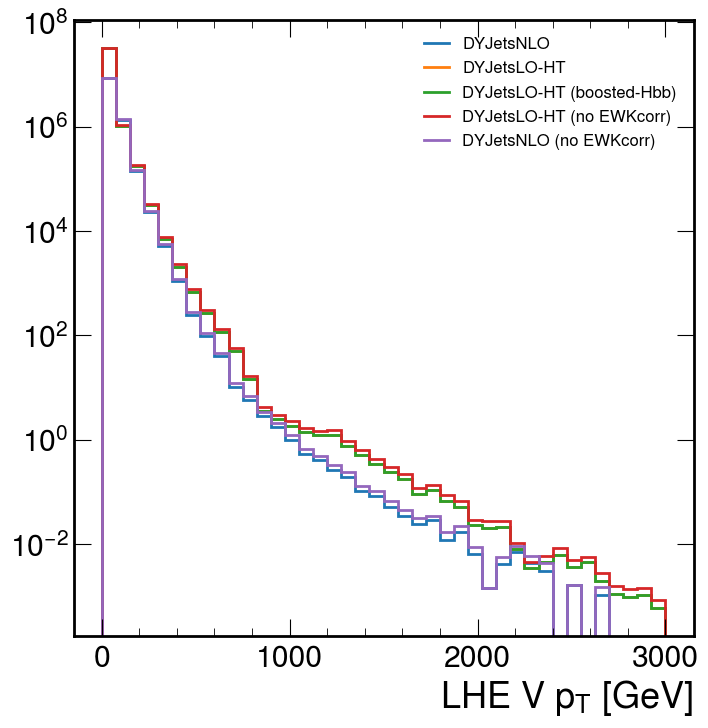

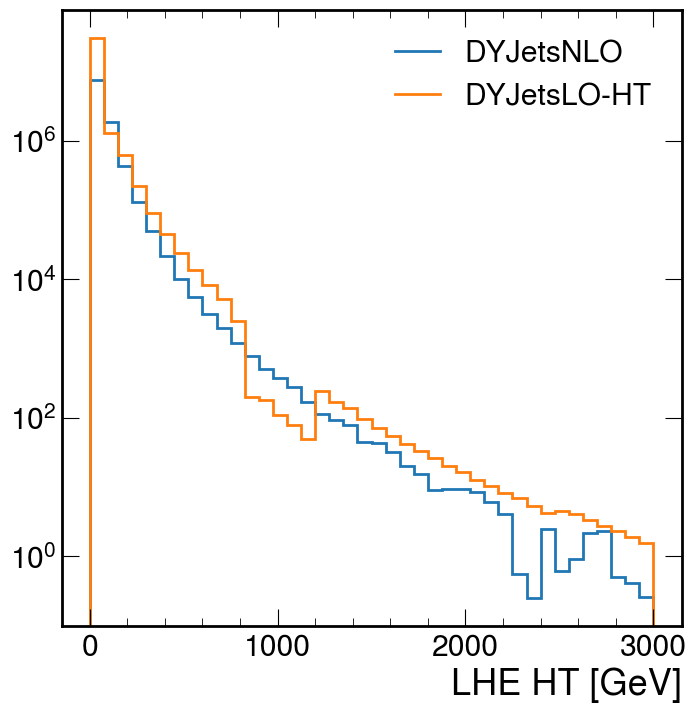

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
mplhep.histplot(h_vpt_oldcorr[{"scat": "DYJetsLO-HT"}], lw=2, flow="none", label="DYJetsLO-HT (boosted-Hbb)")
mplhep.histplot(h_vpt_noewkcorr[{"scat": "DYJetsLO-HT"}], lw=2, flow="none", label="DYJetsLO-HT (no EWKcorr)")
mplhep.histplot(h_vpt_noewkcorr[{"scat": "DYJetsNLO"}], lw=2, flow="none", label="DYJetsNLO (no EWKcorr)")
ax.legend(fontsize=12)
ax.set_yscale("log")

fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["DYJetsNLO", "DYJetsLO-HT"]:
    h = h_ht[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        flow="none",
        label=key,
    )
ax.legend()
ax.set_yscale("log")

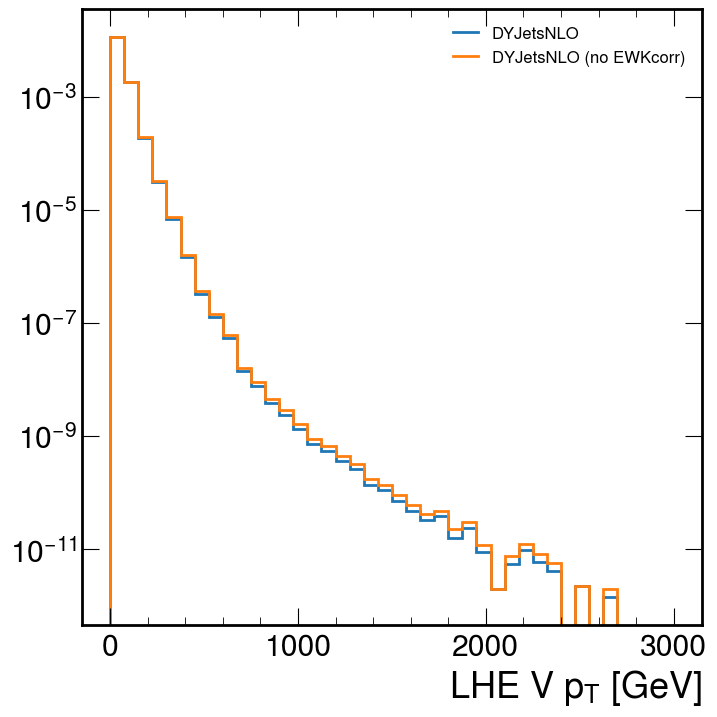

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
mplhep.histplot(h_vpt[{"scat": "DYJetsNLO"}], lw=2, flow="none", label="DYJetsNLO", density=True)
mplhep.histplot(h_vpt_noewkcorr[{"scat": "DYJetsNLO"}], lw=2, flow="none", label="DYJetsNLO (no EWKcorr)", density=True)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("dyjetsnlo_ewkcorr.png")

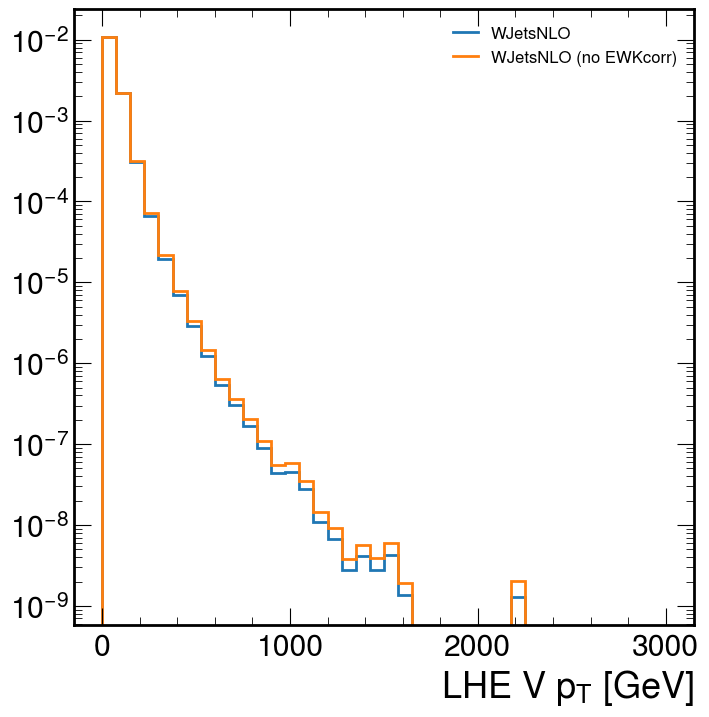

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
mplhep.histplot(h_vpt[{"scat": "WJetsNLO"}], lw=2, flow="none", label="WJetsNLO", density=True)
mplhep.histplot(h_vpt_noewkcorr[{"scat": "WJetsNLO"}], lw=2, flow="none", label="WJetsNLO (no EWKcorr)", density=True)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("wjetsnlo_ewkcorr.png")

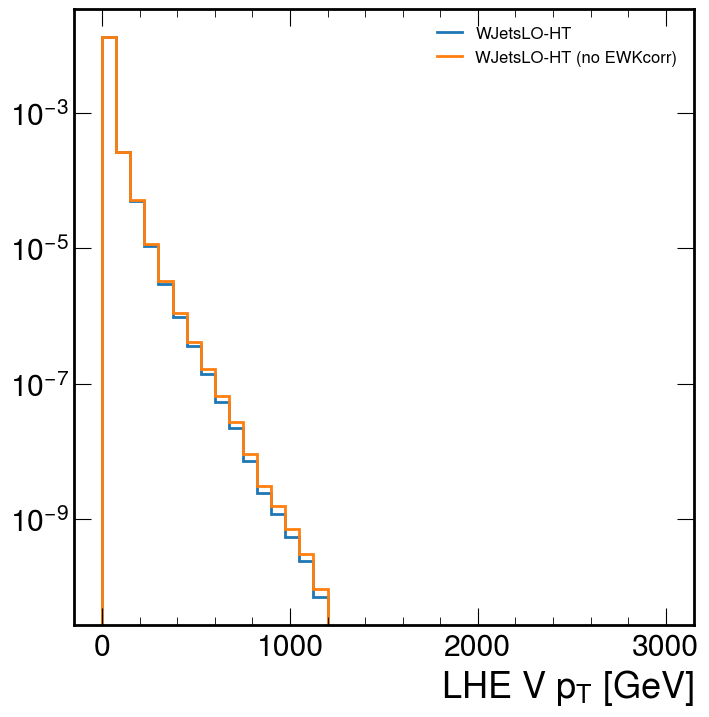

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
mplhep.histplot(h_vpt[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT", density=True)
mplhep.histplot(h_vpt_noewkcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (no EWKcorr)", density=True)
ax.legend(fontsize=12)
ax.set_yscale("log")
fig.savefig("wjetsLO_ewkcorr.png")

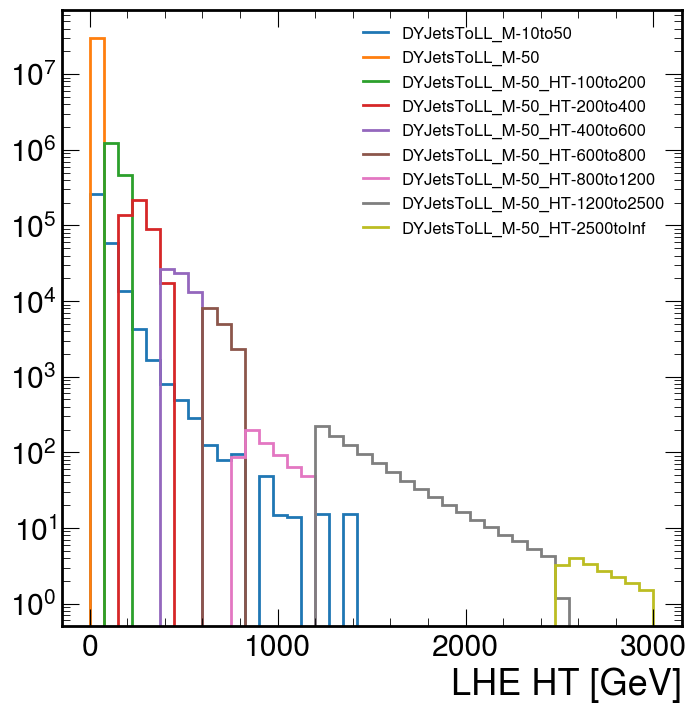

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in samples_dict["DYJetsLO-HT"]:
    h = h_ht_ind[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        #density=True,
        flow="none",
        label=key,
    )
ax.legend(fontsize=12)
ax.set_yscale("log")


In [8]:
pt_axis = hist.axis.Regular(
    40, 0, 3000, name="vpt", label=r"LHE V p$_T$ [GeV]"
)
lpt_axis = hist.axis.Regular(
    40, 0, 1000, name="leppt", label=r"Reco Lepton p$_T$ [GeV]"
)
ht_axis = hist.axis.Regular(
    40, 0, 3000, name="ht", label=r"LHE HT [GeV]"
)
sample_axis = hist.axis.StrCategory([], name="scat", growth=True)
h_vpt = hist.Hist(vpt_axis, sample_axis)
h_vpt_noweight = hist.Hist(vpt_axis, sample_axis)

h_vpt_nocorr = hist.Hist(vpt_axis, sample_axis)
h_vpt_noewkcorr = hist.Hist(vpt_axis, sample_axis)

h_lpt = hist.Hist(lpt_axis, sample_axis)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan6_vjets_lepsel_oldqcdcorr_2018/"
ch = "mu"
year = "2018"
samples_dict = {
    "WJetsNLO": [
        "WJetsToLNu_0J",
        "WJetsToLNu_1J",
        "WJetsToLNu_2J",
    ],
    "WJetsLO-HT": [
        "WJetsToLNu_TuneCP5_13TeV-madgraphMLM",
        #"WJetsToLNu_HT-70To100",
        "WJetsToLNu_HT-100To200",
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
}

for key,samples in samples_dict.items():
    for sample in samples:
        parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")
        print(sample)

        columns = [
            "LHE_HT", 
            "LHE_Vpt", 
            f"weight_{ch}",
            "ewk_corr", "oldqcd_corr", "qcd_corr", 
            "lep_pt"
        ]
        data = pd.read_parquet(parquet_files, columns=columns)

        luminosity = 59781.96

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"]

        if sample=="WJetsToLNu_TuneCP5_13TeV-madgraphMLM" or sample=="DYJetsToLL_M-50":
            selection = (data["LHE_HT"] < 70)
            data = data[selection]
            event_weight = event_weight[selection]

        if len(data) <= 0: continue
        leppt = data["lep_pt"].values
        h_lpt.fill(leppt, key, weight=event_weight)

        hpt = data["LHE_Vpt"].values
        h_vpt.fill(hpt, key, weight=event_weight)

        if "NLO" in sample:
            h_vpt_nocorr.fill(hpt, key, weight=event_weight)
        else:
            qcd_corr = data["oldqcd_corr"].values
            inv_qcd_corr = np.nan_to_num(1/data["oldqcd_corr"])
            w = event_weight*inv_qcd_corr
            h_vpt_nocorr.fill(hpt, key, weight=w)

        inv_ewk_corr = np.nan_to_num(1/data["ewk_corr"].values)
        w = event_weight*inv_ewk_corr
        h_vpt_noewkcorr.fill(hpt, key, weight=w)

WJetsToLNu_0J
WJetsToLNu_1J
WJetsToLNu_2J
WJetsToLNu_TuneCP5_13TeV-madgraphMLM
WJetsToLNu_HT-100To200
WJetsToLNu_HT-200To400
WJetsToLNu_HT-400To600
WJetsToLNu_HT-600To800
WJetsToLNu_HT-800To1200
WJetsToLNu_HT-1200To2500
WJetsToLNu_HT-2500ToInf


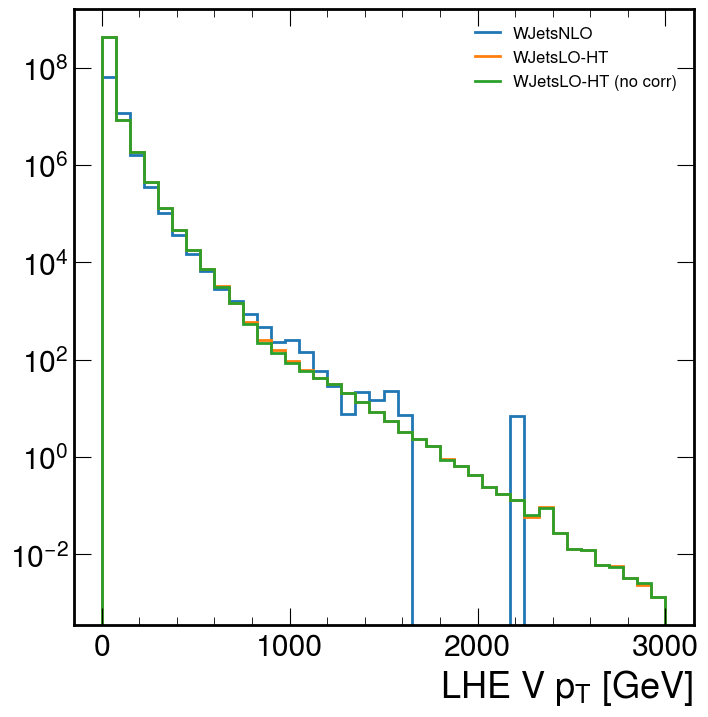

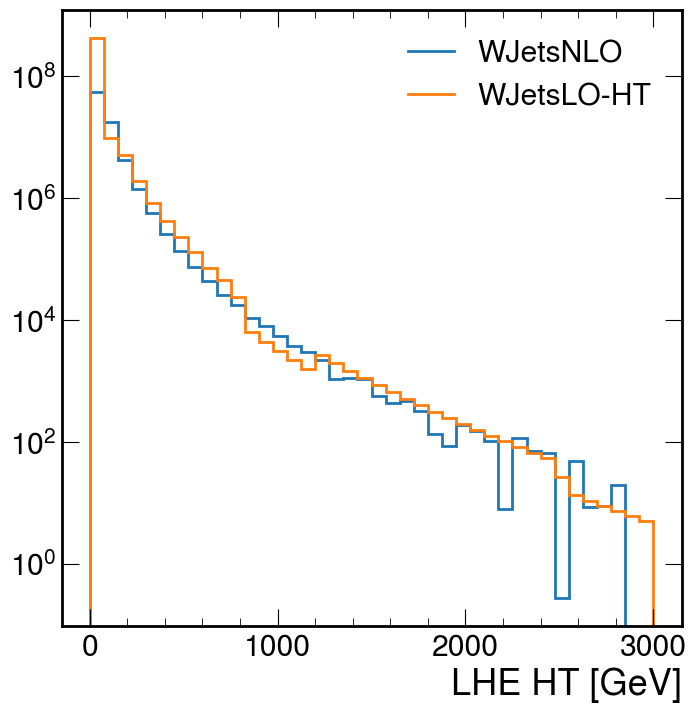

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_vpt[{"scat": key}]
    mplhep.histplot(h, lw=2, flow="none", label=key)
mplhep.histplot(h_vpt_oldcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (no corr)")
#mplhep.histplot(h_vpt_noewkcorr[{"scat": "WJetsLO-HT"}], lw=2, flow="none", label="WJetsLO-HT (no EWKcorr)")
#mplhep.histplot(h_vpt_noewkcorr[{"scat": "WJetsNLO"}], lw=2, flow="none", label="WJetsNLO (no EWKcorr)")
ax.legend(fontsize=12)
ax.set_yscale("log")

fig, ax = plt.subplots(figsize=(8, 8))
legend_elements = []
for key in ["WJetsNLO", "WJetsLO-HT"]:
    h = h_ht[{"scat": key}]
    mplhep.histplot(
        h,
        lw=2,
        flow="none",
        label=key,
    )
ax.legend()
ax.set_yscale("log")